In [4]:
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text('{"username":"origam1","key":"4d8b877658b2d16c2c94012f0a3414e7"}')
    cred_path.chmod(0o600)

In [5]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [13]:
if not path.exists():
    path.mkdir(parents=True,exist_ok=True)
    api.competition_download_cli('bluebook-for-bulldozers',path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')
    
path.ls(file_type='text')

(#7) [Path('/root/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/root/.fastai/archive/bluebook/Machine_Appendix.csv'),Path('/root/.fastai/archive/bluebook/Valid.csv'),Path('/root/.fastai/archive/bluebook/TrainAndValid.csv'),Path('/root/.fastai/archive/bluebook/ValidSolution.csv'),Path('/root/.fastai/archive/bluebook/median_benchmark.csv'),Path('/root/.fastai/archive/bluebook/Test.csv')]

In [14]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [15]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [16]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [17]:
sizes = ['Large','Large / Medium','Medium','Small','Mini','Compact']

In [19]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [20]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [21]:
df = add_datepart(df,'saledate')

In [22]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [23]:
procs = [Categorify, FillMissing]

In [31]:
cond = (df['saleYear'] < 2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [32]:
contin, cat = cont_cat_split(df,1, dep_var=dep_var)

In [34]:
to = TabularPandas(df, procs, cat, contin, y_names=dep_var, splits=splits)

In [35]:
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [36]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [37]:
save_pickle(path/'to.pkl',to)

In [48]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [49]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y)

DecisionTreeRegressor(max_leaf_nodes=4)

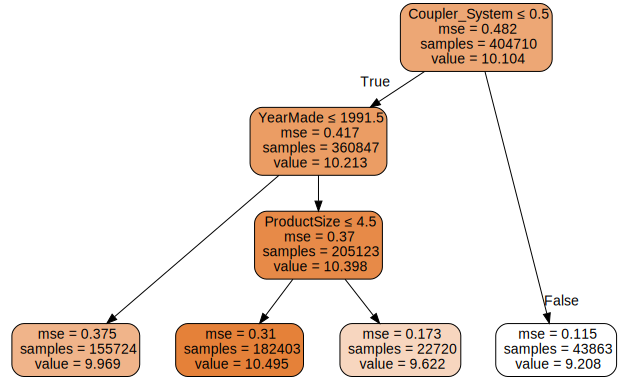

In [50]:
draw_tree(m,xs, size=10, leaves_parallel=True, precision=3)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


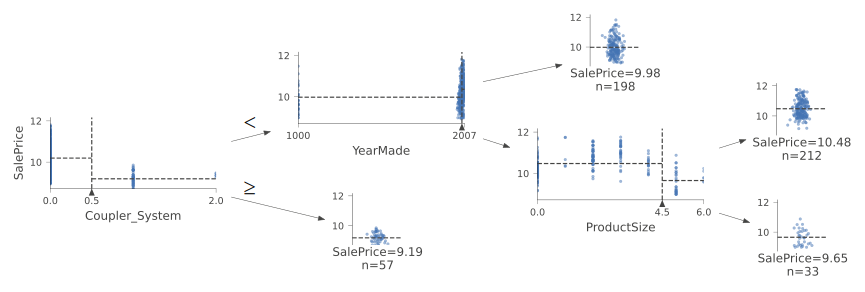

In [53]:
sample_idxs = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[sample_idxs], y.iloc[sample_idxs], xs.columns, dep_var, scale=1.6, label_fontsize=10, orientation='LR')

In [54]:
xs.loc[xs['YearMade'] < 1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

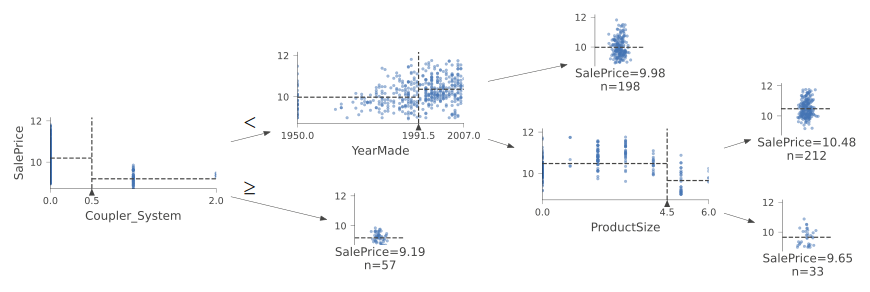

In [57]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[sample_idxs], y.iloc[sample_idxs], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [58]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

In [62]:
def r_mse(pred,y):
    return round(
        math.sqrt(
            ((pred-y)**2).mean()
        ),
        6
    )

def m_rmse(m, xs,y):
    return r_mse(m.predict(xs),y)

In [63]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.0, 0.334974)

In [64]:
m.get_n_leaves()

324556

In [65]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)
m_rmse(m,xs,y), m_rmse(m, valid_xs, valid_y)

(0.211706, 0.26879)

In [66]:
m.get_n_leaves()

12400

In [70]:
def rf(xs, y, n_estimators=60, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True
                                ).fit(xs,y)

In [71]:
m = rf(xs,y)

In [72]:
m_rmse(m, xs,y), m_rmse(m, valid_xs,valid_y)

(0.170407, 0.233851)

In [74]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

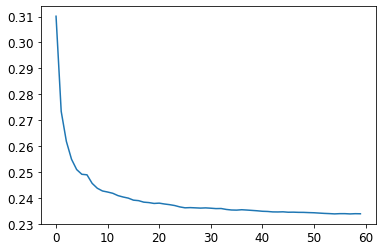

In [84]:
plt.plot([
    r_mse(preds[:i+1].mean(0),valid_y) for i in range(len(preds))
])

In [85]:
def rf_feature_importance(m,df):
    return pd.DataFrame({
        'cols':df.columns,
        'imp':m.feature_importances_
    }).sort_values('imp',ascending=False)

In [86]:
fi = rf_feature_importance(m,xs)
fi[:10]

,cols,imp
59,YearMade,0.181123
31,Coupler_System,0.123946
7,ProductSize,0.118533
8,fiProductClassDesc,0.080869
56,ModelID,0.057266
51,saleElapsed,0.049209
33,Hydraulics_Flow,0.046241
4,fiSecondaryDesc,0.042481
13,Enclosure,0.031622
2,fiModelDesc,0.031593


In [87]:
def plot_feature_importance(fi):
    return fi.plot('cols','imp','barh',figsize=(12,7))

<AxesSubplot:ylabel='cols'>

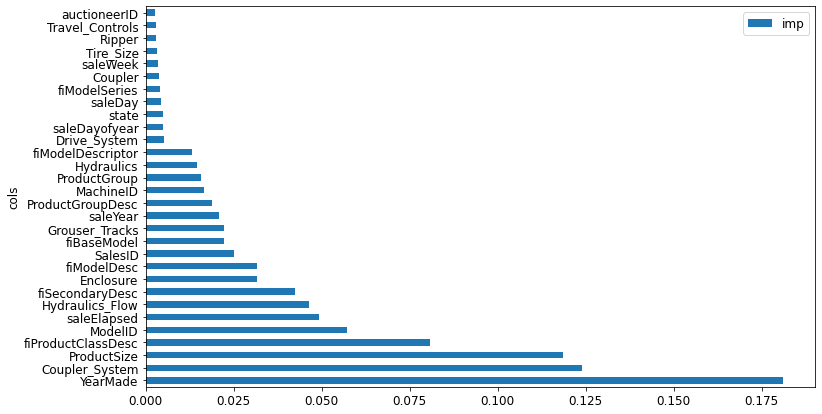

In [88]:
plot_feature_importance(fi[:30])

In [89]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

20

In [91]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [92]:
m = rf(xs_imp,y)

In [93]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.180404, 0.230853)

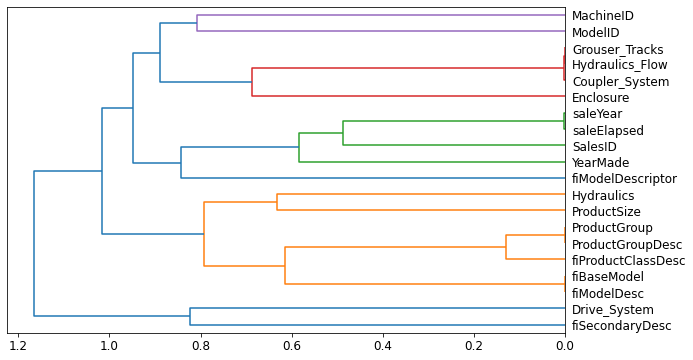

In [94]:
cluster_columns(xs_imp)

In [95]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15, max_samples=50_000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [96]:
get_oob(xs_imp)

0.8769783530196633

In [100]:
{
    c: get_oob(xs_imp.drop(c, axis=1)) for c in (
        'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System'
    )
}

{'saleYear': 0.8760751988144712,
 'saleElapsed': 0.8723409638966857,
 'ProductGroupDesc': 0.8763434517500495,
 'ProductGroup': 0.8771562997504465,
 'fiModelDesc': 0.874476377548453,
 'fiBaseModel': 0.8761066723301962,
 'Hydraulics_Flow': 0.8777436033765784,
 'Grouser_Tracks': 0.8762507701836619,
 'Coupler_System': 0.8759126761895646}

In [101]:
to_drop = ['saleYear', 'ProductGroupDesc','fiBaseModel','Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8754076739209511

In [102]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [103]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl',valid_xs_final)

([<matplotlib.axis.YTick at 0x7f0fa6e0c970>,
 [Text(0, 0, '#na#'),
  Text(0, 1, 'Large'),
  Text(0, 2, 'Large / Medium'),
  Text(0, 3, 'Medium'),
  Text(0, 4, 'Small'),
  Text(0, 5, 'Mini'),
  Text(0, 6, 'Compact')])

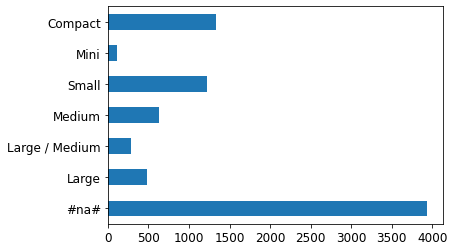

In [106]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)

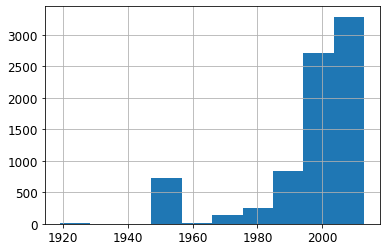

In [108]:
ax = valid_xs_final['YearMade'].hist()

In [119]:
m = rf(xs_final,y)

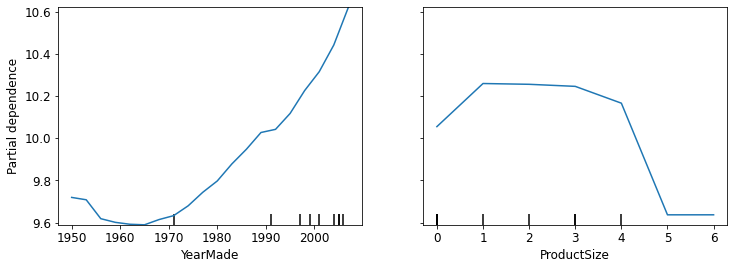

In [110]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'], grid_resolution=20, ax=ax)

In [113]:
import warnings
warnings.simplefilter('ignore',FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [115]:
row = valid_xs_final.iloc[:5]

In [120]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

<module 'matplotlib.pyplot' from '/root/miniconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

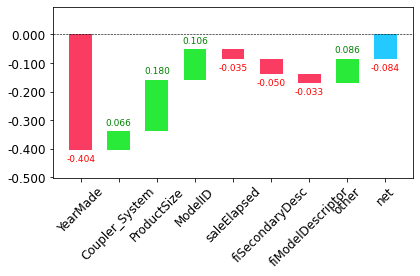

In [127]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, rotation_value=45,  formatting='{:,.3f}')

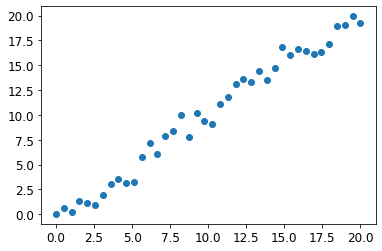

In [142]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [147]:
xs_lin = x_lin.view(-1,1)
xs_lin.shape, x_lin[:,None].shape, x_lin.unsqueeze(1).shape, x_lin.unsqueeze(0).shape

(torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([1, 40]))

In [145]:
y_lin.shape

torch.Size([40])

In [148]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

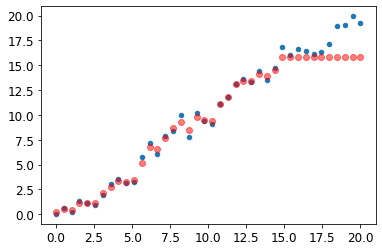

In [152]:
plt.scatter(x_lin,y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red',alpha=0.5)

In [154]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feature_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.896596
10,SalesID,0.084064
11,MachineID,0.015742
0,YearMade,0.000927
4,ModelID,0.000687
13,Hydraulics,0.000420


In [156]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed', 'MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 0.232359
SalesID 0.230688
saleElapsed 0.234642
MachineID 0.23075


In [158]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time,y)
m_rmse(m, valid_xs_time, valid_y)

0.229816

<AxesSubplot:>

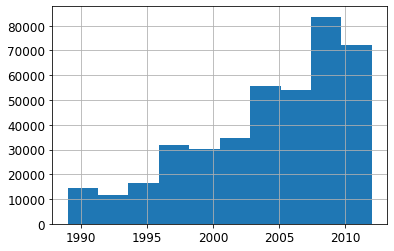

In [159]:
xs['saleYear'].hist()

In [161]:
filt = xs['saleYear'] > 2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [162]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt,y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.17671, 0.228896)

In [163]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [164]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [165]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [166]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [173]:
df_nn['saleElapsed'] = df_nn['saleElapsed'].astype(int)

In [178]:
df_nn_final['saleElapsed']

0         1163635200
1         1080259200
2         1077753600
3         1305763200
4         1248307200
             ...    
412693    1331078400
412694    1327708800
412695    1327708800
412696    1331078400
412697    1327708800
Name: saleElapsed, Length: 412698, dtype: int64

In [169]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
ProductGroup             6
Hydraulics              12
fiModelDescriptor      140
Drive_System             4
dtype: int64

In [170]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.178586, 0.230393)

In [171]:
cat_nn.remove('fiModelDescriptor')

In [179]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn =TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [183]:
dls = to_nn.dataloaders(1024)

In [185]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

In [187]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0002754228771664202)

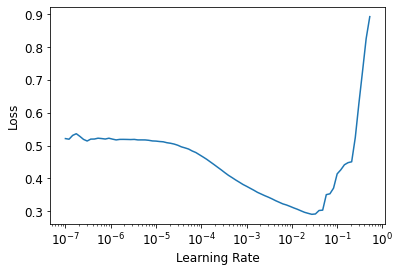

In [188]:
learn.lr_find()

In [189]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.069514,0.066720,00:10
1,0.056086,0.056367,00:10
2,0.048495,0.055104,00:10
3,0.043729,0.051227,00:10
4,0.040635,0.051157,00:10


In [190]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.226178

In [191]:
preds[:10], targs[:10]

(tensor([[10.2247],
         [10.0421],
         [ 9.4107],
         [ 9.0511],
         [10.1288],
         [10.6360],
         [ 9.7304],
         [ 9.7304],
         [10.3762],
         [11.0899]]),
 tensor([[10.0432],
         [10.0858],
         [ 9.3927],
         [ 8.8537],
         [10.1266],
         [10.5187],
         [ 9.5819],
         [ 9.4727],
         [10.2751],
         [11.0821]]))

In [194]:
learn.save('nn')

Path('models/nn.pth')

In [197]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(73, 18)
    (1): Embedding(3, 3)
    (2): Embedding(7, 5)
    (3): Embedding(75, 18)
    (4): Embedding(5242, 194)
    (5): Embedding(4, 3)
    (6): Embedding(178, 29)
    (7): Embedding(7, 5)
    (8): Embedding(5060, 190)
    (9): Embedding(7, 5)
    (10): Embedding(13, 7)
    (11): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(482, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=482, out_features=500, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=500, out_features=250, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=25

In [200]:
[c for c,v in learn.dls.classes.items()]

['YearMade',
 'Coupler_System',
 'ProductSize',
 'fiProductClassDesc',
 'ModelID',
 'Hydraulics_Flow',
 'fiSecondaryDesc',
 'Enclosure',
 'fiModelDesc',
 'ProductGroup',
 'Hydraulics',
 'Drive_System']